In [1]:
import random
import time
from collections import namedtuple
import copy
import tqdm
import gymnasium as gym

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math 
import torch.nn.functional as F
%matplotlib inline

In [2]:
env = gym.make('CartPole-v1')
env_vis = gym.make('CartPole-v1', render_mode="rgb_array")  # visualization env

In [3]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import display as ipy_display, clear_output

In [4]:
def render_env(env, policy=None, max_steps=100, fps=50):
    """
    Graphically render the env using the given policy.
    If policy is None, random policy used.
    """

    plt.ion()

    if policy is None:
        def policy(state):
            # random policy
            return env.action_space.sample()

    state, info = env.reset()
    img = plt.imshow(env.render())

    for _ in range(max_steps):
        action = policy(state)
        img.set_data(env.render())
        plt.axis("off")
        ipy_display(plt.gcf())
        clear_output(wait=True)
        next_state, reward, terminated, truncated, info = env.step(action)
        state = next_state

        if terminated or truncated:
            env.reset()

    
    plt.ioff()
    #env.close()


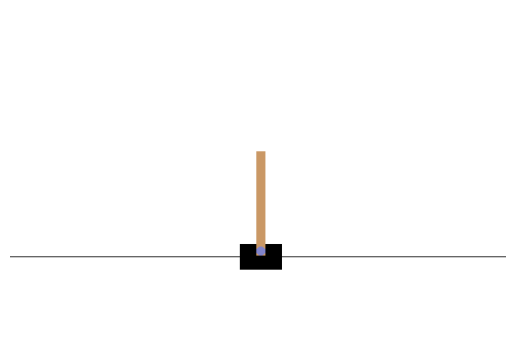

In [5]:
render_env(env_vis)

In [6]:
class ExponentialSchedule:
    def __init__(self, initial_value, final_value, num_steps):
        """
        Exponential schedule from initial_value to final_value in num_steps.
        $ value(t) = a * exp(b*t) $
        Determines the probability with which we will choose a random action. 
        This value is high initially to encourage exploration, and is gradually reduced as we approach optimal Q-values.
        """
        self.initial_value = initial_value
        self.final_value = final_value
        self.num_steps = num_steps

        self.a = initial_value
        self.b = np.log(self.final_value/self.initial_value) / (self.num_steps - 1)

    def value(self, step) -> float: 
        if step<=0:
            return self.initial_value
        elif step >= self.num_steps:
            return self.final_value
        return self.a * np.exp(step * self.b)
            

In [7]:
# Test schedule
def _test_schedule(schedule, step, value, tol=1e-5):
    """
    Tests that the schedule returns the correct value
    Args:
        - schedule: schedule object
        - step: timestep
        - value: expected value
        - ndigits: decimal point accuracy
    """
    v = schedule.value(step)
    diff = abs(v - value)
    assert diff <= tol, (f'For step {step}, the scheduler returned {v} instead of {value}')
    print(f"Correct exponential schedule at step {step}.")
        

_schedule = ExponentialSchedule(0.1, 0.2, 3)
_test_schedule(_schedule, -1, 0.1)
_test_schedule(_schedule, 0, 0.1)
_test_schedule(_schedule, 1, 0.141421356237309515)
_test_schedule(_schedule, 2, 0.2)
_test_schedule(_schedule, 3, 0.2)
del _schedule

_schedule = ExponentialSchedule(0.5, 0.1, 5)
_test_schedule(_schedule, -1, 0.5)
_test_schedule(_schedule, 0, 0.5)
_test_schedule(_schedule, 1, 0.33437015248821106)
_test_schedule(_schedule, 2, 0.22360679774997905)
_test_schedule(_schedule, 3, 0.14953487812212207)
_test_schedule(_schedule, 4, 0.1)
_test_schedule(_schedule, 5, 0.1)
del _schedule

Correct exponential schedule at step -1.
Correct exponential schedule at step 0.
Correct exponential schedule at step 1.
Correct exponential schedule at step 2.
Correct exponential schedule at step 3.
Correct exponential schedule at step -1.
Correct exponential schedule at step 0.
Correct exponential schedule at step 1.
Correct exponential schedule at step 2.
Correct exponential schedule at step 3.
Correct exponential schedule at step 4.
Correct exponential schedule at step 5.


In [8]:
Batch = namedtuple('Batch', ('states', 'actions', 'rewards', 'next_states', 'dones'))

class ReplayMemory:
    def __init__(self, max_size, state_size):
        """
        Replay memory implemented as a circular buffer.
        Experiences will be removed in a FIFO manner on reaching max_size.
        Args:
            - max_size: Maximum size of the buffer
            - state_size: size of state-space features for the env
        """
        self.max_size = max_size
        self.state_size = state_size
        self.size = 0 # current buffer size

        # Preallocating memory for speed
        self.states = torch.empty((max_size, state_size))
        self.actions = torch.empty((max_size, 1), dtype = torch.long)
        self.rewards = torch.empty((max_size,1))
        self.next_states = torch.empty((max_size, state_size))
        self.dones = torch.empty((max_size, 1), dtype=torch.bool)

        # pointer to current location in the circular buffer
        self.idx = 0

        # number of transitions currently stored in the buffer
        self.size = 0

    def add(self, state, action, reward, next_state, done):
        """
        Add a transition to the buffer.
        Args:
            - state: 1-D np.ndarray of size state_size consisting of state features 
            - action: integer action
            - reward: float reward
            - next_state: 1D np.ndarray of state-features
            - done: boolean value indicating end of epiosde (terminated/truncated)
        """
        # store transitions (convert from numpy arrays to tensors)
        self.states[self.idx] = torch.tensor(state, dtype=torch.float32)
        self.actions[self.idx] = torch.tensor(action, dtype=torch.float32)
        self.rewards[self.idx] = torch.tensor(reward, dtype=torch.float32)
        self.next_states[self.idx] = torch.tensor(next_state, dtype=torch.float32)
        self.dones[self.idx] = torch.tensor(done, dtype=torch.float32)

        # update current pointer
        self.idx = (self.idx + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size) -> Batch:
        """
        Sample a batch of experiences.
        If the buffer contains less than 'batch_size' transitions, sample all of them.
        Args:
            - batch_size: Number of transitions to sample
        Returns:
            - a batch of experiences of type 'Batch'
        """
        # number of samples to pick
        effective_batch_size = min(batch_size, self.size)

        sample_indices = np.random.choice(self.size, effective_batch_size, replace=False)
        # sample indices can range from 0 to self.size, sample size should be 'effective_batch_size'
        
        batch = Batch(states = self.states[sample_indices],
                      actions = self.actions[sample_indices],
                      rewards = self.rewards[sample_indices],
                      next_states = self.next_states[sample_indices],
                      dones = self.dones[sample_indices])
        return batch
        
        
    def populate(self, env, num_steps):
        """
        Populates replay memory with 'num_steps' from random policy.
        """
        state, info = env.reset()
        for i in range(num_steps):
            action = env.action_space.sample()
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            self.add(state, action, reward, next_state, done)

            if done:
                state, info = env.reset()
            else:
                state = next_state        
                   

In [9]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, *, num_layers=3, hidden_dim=256):
        super().__init__()
        """
        Deep Q-Network Pytorch model.
        Args:
            - state_dim: Dimensionality of states
            - action_dim: Dimensionality of actions
            - num_layers: Number of total linear layers
            - hidden dim: Number of neurons in the hidden layer
        """
        self.state_dim = state_dim
        self.hidden_dim = hidden_dim
        self.action_dim = action_dim
        self.num_layers = num_layers
        
        self.layer1 = nn.Linear(state_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, action_dim)

    
    def forward(self, x) -> torch.Tensor:
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x


    def custom_dump(self):
        return {
            'args': (self.state_dim, self.action_dim),
            'kwargs': {
                'num_layers': self.num_layers,
                'hidden_dim': self.hidden_dim,
            },
            'state_dict': self.state_dict(),
        }
    
    @classmethod
    def custom_load(cls, data):
        model = cls(*data['args'], **data['kwargs'])
        model.load_state_dict(data['state_dict'])
        return model
    

In [10]:
# Test code
def _test_dqn_forward(dqn_model, input_shape, output_shape):
    """ Tests if DQN returns correctly shaped tensors. """
    inputs = torch.torch.randn((input_shape))
    outputs = dqn_model(inputs)

    if not isinstance(outputs, torch.FloatTensor):
        raise Exception(f"DQN.forward returned type {type(outputs)} instead of torch.Tensor")

    if outputs.shape != output_shape:
        raise Exception(f'DQN.forward returned tensor with shape {outputs.shape} instead of {output_shape}')

    if not outputs.requires_grad:
        raise Exception(f'DQN.forward returned tensor that doesn not require a gradient (it should!)')


dqn_model = DQN(10,4)
_test_dqn_forward(dqn_model, (64,10), (64,4))
_test_dqn_forward(dqn_model, (2,3,10), (2,3,4))
del dqn_model    

In [11]:
def train_dqn_batch(optimizer, batch, dqn_model, dqn_target, gamma) -> float:
    """Performs a single batch update step on given dqn_model.
    Args:
        - optimizer: nn.optim.Optimizer instance
        - batch: Batch of experiences (type Batch)
        - dqn_model: DQN model to be trained
        - gamma: discount factor
    rtpe: Float. scalar loss for this batch
    """
    values = dqn_model(batch.states).gather(1, batch.actions)
    with torch.no_grad():
        next_q_values = dqn_target(batch.next_states).max(1, keepdim=True)[0]
        target_values = batch.rewards + gamma *next_q_values * (~batch.dones)

    # Tests
    assert (values.shape == target_values.shape), 'Shapes of values tensor and target values tensor do not match.'
    assert (values.requires_grad), 'values tensor requires gradients.'
    assert (not target_values.requires_grad), 'target_values tensor should not require gradients.'

    loss = F.mse_loss(values, target_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

In [12]:
def train_dqn(env, num_steps, *, num_saves = 5, replay_size, replay_prepopulate_steps=0, batch_size, exploration, gamma):
    """
    DQN algorithm.

    Compared to previous training procedures, we will train for a given number
    of time-steps rather than a given number of episodes. The number of
    time-steps will be in the range of millions, which still results in many
    episodes being executed.

    Args:
        - env: The Gymnasium environment
        - num_steps: Total number of steps to be used for training
        - num_saves: How many models to save to analyze the training progress
        - replay_size: Maximum size of the ReplayMemory
        - replay_prepopulate_steps: Number of steps with which to prepopulate
                                    the memory
        - batch_size: Number of experiences in a batch
        - exploration: An ExponentialSchedule
        - gamma: The discount factor

    Returns: (saved_models, returns)
        - saved_models: Dictionary whose values are trained DQN models
        - returns: Numpy array containing the return of each training episode
        - lengths: Numpy array containing the length of each training episode
        - losses: Numpy array containing the loss of each training batch
    """
    # Check that env states are compatible with our DQN representation
    assert (isinstance(env.observation_space, gym.spaces.Box) and len(env.observation_space.shape) == 1)

    state_size = env.observation_space.shape[0]

    # initialze model and target
    dqn_model = DQN(state_size, env.action_space.n)
    dqn_target = DQN.custom_load(dqn_model.custom_dump())

    optimizer = torch.optim.Adam(dqn_model.parameters())

    memory = ReplayMemory(replay_size, state_size)
    memory.populate(env, replay_prepopulate_steps)

    rewards = []
    returns = []
    lengths = []
    losses = []

    # Initialize structures to save models at different stages of training
    t_saves = np.linspace(0, num_steps, num_saves-1, endpoint=False)
    saved_models = {}
    i_episode = 0 # index of current episode
    t_episode = 0 # time-step inside current episode

    state, _ = env.reset()
    G = 0

    # Iterate for a total of 'num_steps' steps
    pbar = tqdm.trange(num_steps)
    for t_total in pbar:
        # t_total: time-step from the beginning of training 
        if t_total in t_saves:
            model_name = f'{100*t_total / num_steps:04.1f}'.replace('.', '_')
            saved_models[model_name] = copy.deepcopy(dqn_model)

        eps_value = exploration.value(t_total)
        if np.random.rand() < eps_value:
            action = env.action_space.sample()
        else:
            action = dqn_model(torch.tensor(state, dtype=torch.float32)).argmax().item()

        next_state, reward, done, trunc, _ = env.step(action)
        memory.add(state, action, reward, next_state, done)
        state = next_state
        G += reward
        t_episode += 1

        # Once every 4 steps, sample a batch from replay memory and perform a batch update
        if t_total%4 == 0:
            batch = memory.sample(batch_size)
            loss = train_dqn_batch(optimizer, batch, dqn_model, dqn_target, gamma)
            losses.append(loss)

        # update target network every 10k steps
        if t_total % 1_000 == 0:
            dqn_target.load_state_dict(dqn_model.state_dict())

        if done or trunc:
            returns.append(G)
            rewards.append(reward)
            lengths.append(t_episode)
            pbar.set_description(f'Episode: {i_episode} | Steps: {t_episode+1} | Return : {G:5.2f} | Epsilon: {eps_value:4.2f}')
            state, _ = env.reset()
            G = 0
            t_episode = 0
            i_episode += 1

    saved_models['100_0'] = copy.deepcopy(dqn_model)
    return (saved_models, np.array(returns), np.array(lengths), np.array(losses))

In [13]:
def moving_average(data, *, window_size=50):
    """Smooths 1-D data array using a moving average.

    Args:
        data: 1-D numpy.array
        window_size: Size of the smoothing window

    Returns:
        smooth_data: A 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(np.ones_like(data), kernel)
    return smooth_data[: -window_size+1]

In [38]:
# Values for debugging, change all values later
gamma = 0.99
num_steps = 150_000
num_saves = 25
replay_size = 2_000
replay_prepopulate_steps = 5_00
batch_size = 64
exploration = ExponentialSchedule(1.0, 0.05, 1_000)

dqn_models, returns, lengths, losses = train_dqn(
    env, num_steps,
    num_saves = num_saves,
    replay_size = replay_size,
    replay_prepopulate_steps = replay_prepopulate_steps,
    batch_size = batch_size,
    exploration = exploration,
    gamma = gamma)

# print(len(dqn_models))
assert len(dqn_models) == num_saves
assert all(isinstance(value, DQN) for value in dqn_models.values())

# saving computed models to disk
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models.items()}
torch.save(checkpoint, f'checkpoint_{env.spec.id}.pt')    


Episode: 1049 | Steps: 351 | Return : 350.00 | Epsilon: 0.05: 100%|█| 150000/150


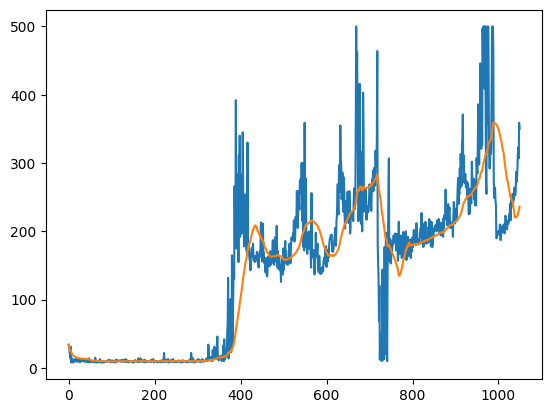

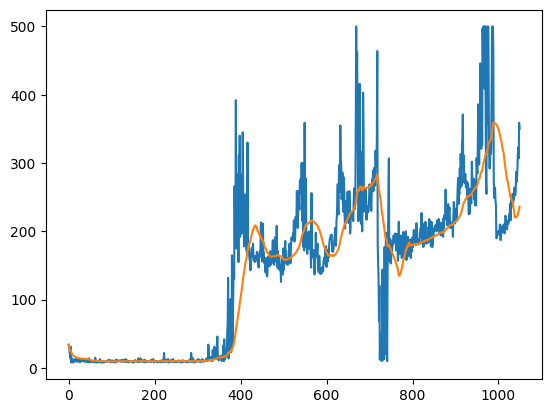

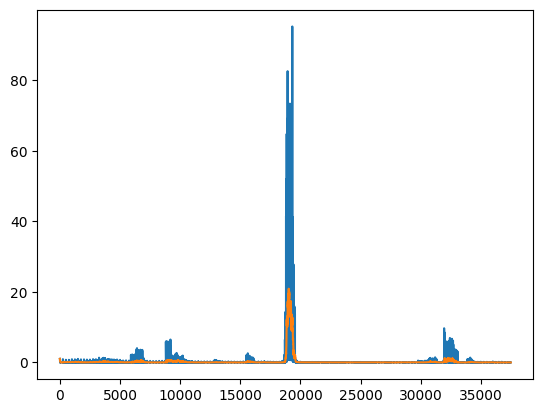

In [39]:
plt.plot(returns)
plt.plot(moving_average(returns))
plt.show()
plt.plot(lengths)
plt.plot(moving_average(lengths))
plt.show()
plt.plot(losses)
plt.plot(moving_average(losses))
plt.show()

In [40]:
model_trained = torch.load("checkpoint_CartPole-v1.pt", map_location="cpu", weights_only=False)

In [41]:
cp = torch.load("checkpoint_CartPole-v1.pt", weights_only=False)

print(type(cp))
print(cp.keys())

<class 'dict'>
dict_keys(['00_0', '04_2', '08_3', '12_5', '16_7', '20_8', '25_0', '29_2', '33_3', '37_5', '41_7', '45_8', '50_0', '54_2', '58_3', '62_5', '66_7', '70_8', '75_0', '79_2', '83_3', '87_5', '91_7', '95_8', '100_0'])


In [42]:
final_model = model_trained['100_0']

In [43]:
print(type(final_model))
print(final_model.keys())

<class 'dict'>
dict_keys(['args', 'kwargs', 'state_dict'])


In [44]:
model_dict = final_model  

# Reconstruct the model using the stored args and kwargs
loaded_model = DQN(*model_dict['args'], **model_dict['kwargs'])

# Load the trained weights
loaded_model.load_state_dict(model_dict['state_dict'])

# Set to evaluation mode
loaded_model.eval()

DQN(
  (layer1): Linear(in_features=4, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=2, bias=True)
)

In [45]:
state, _ = env.reset()
done = False
t = 0.0
while not done and t<300:
    t += 1
    action = loaded_model(torch.tensor(state, dtype=torch.float32)).argmax().item()
    next_state, reward, done, trunc, _ = env.step(action)
    state = next_state

In [46]:
t

300.0

In [47]:
final_model = model_trained['87_5']

In [48]:
model_dict = final_model 
loaded_model = DQN(*model_dict['args'], **model_dict['kwargs'])
loaded_model.load_state_dict(model_dict['state_dict'])
loaded_model.eval()
state, _ = env.reset()
done = False
t = 0.0
while not done and t<300:
    t += 1
    action = loaded_model(torch.tensor(state, dtype=torch.float32)).argmax().item()
    next_state, reward, done, trunc, _ = env.step(action)
    state = next_state
t

300.0